In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle

In [2]:
import scan
import simulate_data

In [3]:
import h5py
f = h5py.File(r'C:/Users/miles/Projects/datasets/heidelberg/shd_train.h5')

In [4]:
'''
My first intuition tells me that I am most likely to find common patterns among speakers saying the same number...

Approach:
> Find patterns that are present in all trials of a speaker saying one number. 
> Do they appear elsewhere?
'''

'\nMy first intuition tells me that I am most likely to find common patterns among speakers saying the same number...\n\nApproach:\n> Find patterns that are present in all trials of a speaker saying one number. \n> Do they appear elsewhere?\n'

In [5]:
np.unique(list(f['extra']['speaker'])) #


array([ 0,  1,  2,  3,  6,  7,  8,  9, 10, 11], dtype=uint16)

In [6]:
speaker = 0
label = 0
filt_idc = np.where((np.array(f['extra']['speaker'])==speaker) & (np.array(f['labels'])==label))[0]
# print(np.sum(filt_idc))

In [7]:
filt_idc

array([ 138,  401,  457,  547,  591,  639,  659,  800,  849,  985, 1028,
       1260, 1686, 1758, 1818, 2161, 2605, 2857, 3099, 3223, 3475, 3715,
       4073, 4118, 4232, 4247, 4275, 4526, 4540, 5094, 5154, 5689, 5774,
       5844, 6102, 6248, 6440, 6619, 6623, 6757, 6785, 6912, 7033, 7104,
       7221, 7578, 7582, 7885], dtype=int64)

In [21]:
def get_imgs(N, pattern_template):
    if len(pattern_template) == 0:
        print('FAIL')
        return pattern_template, None
    
    win_size = (N,1+max([max(k[:,0]) for k in pattern_template]))
    pattern_img = np.zeros((len(pattern_template),*win_size))
    for p,pattern in enumerate(pattern_template):
        for (i,j) in pattern:
            pattern_img[p,j,i] = 1
            
    pattern_img = pattern_img.transpose((1,2,0))
    
    return pattern_template, pattern_img

## Individual spoken numbers

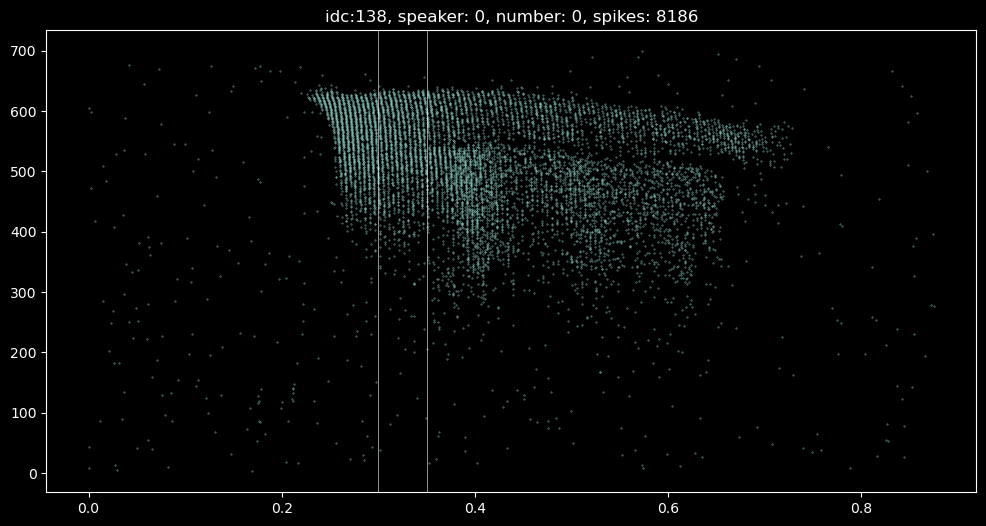

In [206]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))
i=filt_idc[0]
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
D=50/1000
times = f['spikes']['times'][i]
units = f['spikes']['units'][i]
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

plt.title(f'idc:{i}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.show()

In [99]:
# Convert the data into something that is easily readable by my parameter scan algo.

if not os.path.isfile(''.join((os.getcwd(),f'\\{i}-{int(D*1000)}.pkl'))):
    pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = scan.scan_raster((times*1000).astype('int'), units,window_dim=int(D*1000))
    print(f'run_time: {window_time+cluster_time+sequence_time} s')

    results_scan = {
        'pattern_template':pattern_template,
        'sublist_keys_filt':sublist_keys_filt,
        'window_time':window_time,
        'cluster_time':cluster_time,
        'sequence_time':sequence_time
    }

    import pickle 
    with open(f'{i}-{int(D*1000)}.pkl', 'wb') as file:  # open a text file
        pickle.dump(results_scan, file) # serialize the list
    file.close()
else:
    with open(f'{i}-{int(D*1000)}.pkl', 'rb') as file:
        results_scan = pickle.load(file)
    file.close()
    print(f'{i}-{int(D*1000)}.pkl loaded!')


8186 Windows
85 patterns found...... 99% 10.01 | opt_cutoff - 1.37 | most_detections - 8etections - 8
run_time: 77.2961540222168 s


In [122]:
pattern_template = results_scan['pattern_template']

In [125]:
np.array([len(k) for k in pattern_template]) # number of points in the pattern

array([   4,    2,  310,   65,    2,    4,  229,   94,   70,    4,  163,
        213,  395,  443,  133,  118,  216,  193,  142,  383,  353,    5,
        862,  371,  122,  101,  198,  202,  204,  328,  493,   60, 1121,
        141,  117,   78, 1016,    4,  143,  288,  537,  463,  430,  180,
        104,  127,  117,   94,  150,   11,  195,  404,  104,   56,   73,
       1125,  287,  588,  278,  111,   25,  101,   48,   52,  189,  236,
        193,  141,  441,  495,  110,  245,  138,    7,   11,   61,  329,
         52,  520,  553,  205,  107,  295,  302,  336])

In [127]:
pattern_template_copy, pattern_img = get_imgs(max(units),pattern_template)

In [135]:
raster = np.zeros((max((times*1000).astype('int'))+1, max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]-1]=1
print('done')

(876, 699) (699, 199, 85)
done


In [138]:
D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:24<00:00,  3.44it/s]


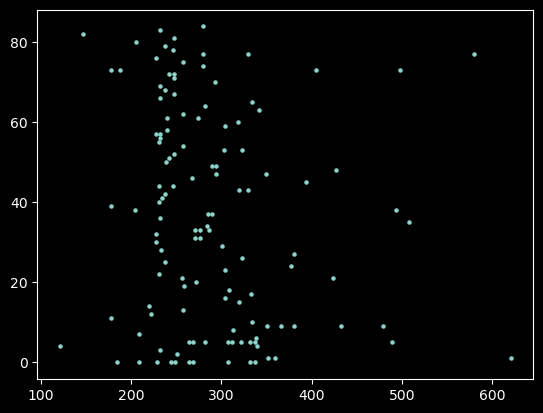

In [141]:
plt.figure()
plt.scatter(*np.where(sanity_check==1), s=5)
plt.show()

In [151]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
patterns[counts>2], counts[counts>2], [len(k) for k in pattern_template[patterns[counts>2]]]

(array([ 0,  1,  5,  9, 33, 73, 77], dtype=int64),
 array([10,  3,  9,  5,  3,  4,  3]),
 [4, 2, 4, 4, 141, 7, 52])

In [197]:
counts

array([10,  3,  1,  1,  2,  9,  1,  1,  1,  5,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  3,
        1,  1,  1,  2,  2,  1,  1,  1,  1,  2,  2,  1,  1,  2,  1,  2,  1,
        1,  1,  2,  1,  1,  1,  2,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  4,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,  1])

0 0
1 1
2 5
3 9
4 33
5 73
6 77


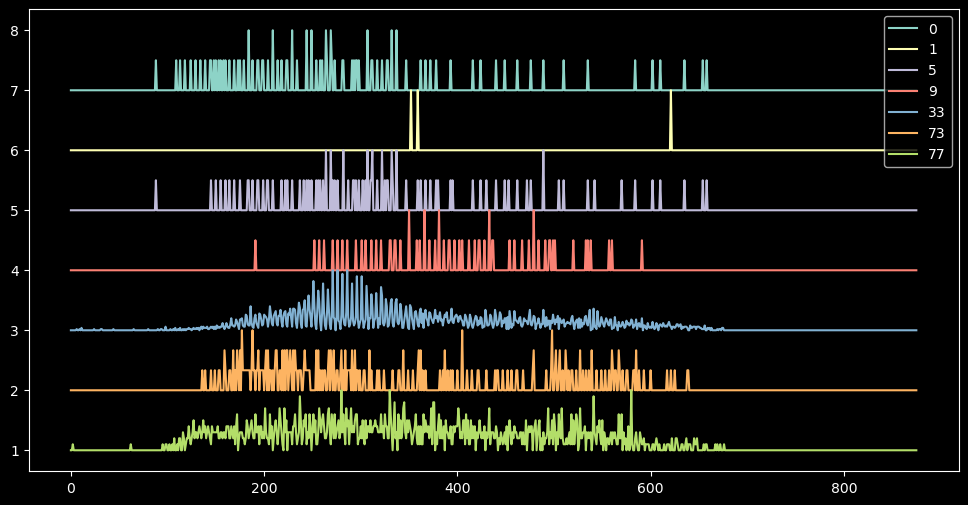

In [200]:
plt.figure(figsize=(12,6))
for i,k in enumerate(patterns[counts>2]):
    print(i,k)
    plt.plot(sanity_check[:,k]+len(patterns[counts>2])-i,label=k)
    plt.legend()
plt.show()

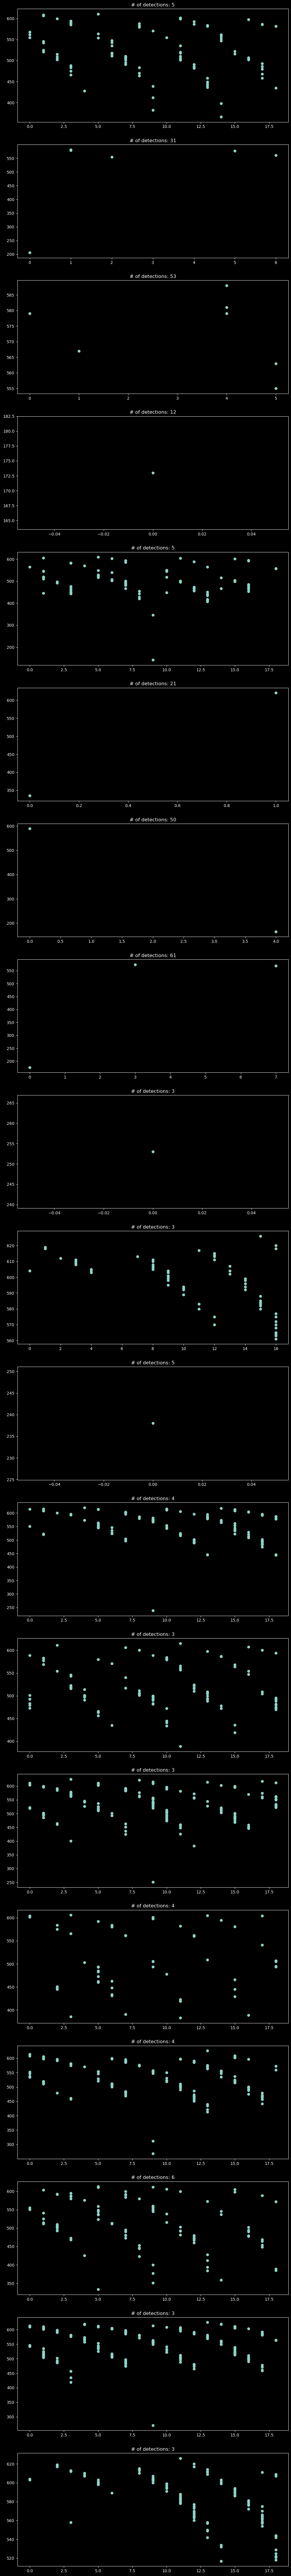

In [29]:
fig,ax = plt.subplots(len(patterns[counts>2]),figsize=(12,6*len(patterns[counts>2])))
for i in range(len(patterns[counts>2])):
    ax[i].scatter(*pattern_template[i].T)
    ax[i].set_title(f'# of detections: {counts[counts>2][i]}')
plt.show()

In [201]:
# Okay let's look at another one

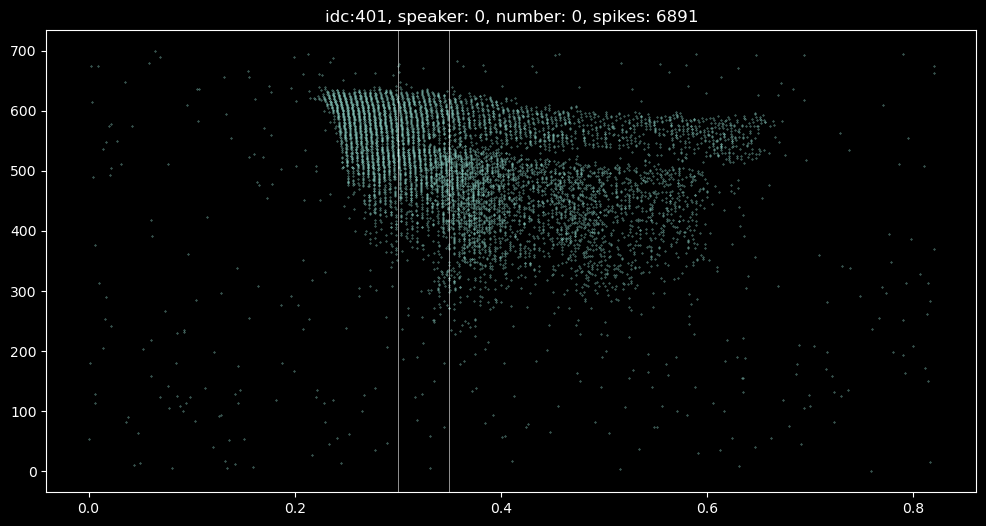

In [207]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))
i=filt_idc[1]
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
D=50/1000
times = f['spikes']['times'][i]
units = f['spikes']['units'][i]
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

plt.title(f'idc:{i}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.show()

In [208]:
# Convert the data into something that is easily readable by my parameter scan algo.

if not os.path.isfile(''.join((os.getcwd(),f'\\{i}-{int(D*1000)}.pkl'))):
    pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = scan.scan_raster((times*1000).astype('int'), units,window_dim=int(D*1000))
    print(f'run_time: {window_time+cluster_time+sequence_time} s')

    results_scan = {
        'pattern_template':pattern_template,
        'sublist_keys_filt':sublist_keys_filt,
        'window_time':window_time,
        'cluster_time':cluster_time,
        'sequence_time':sequence_time
    }

    import pickle 
    with open(f'{i}-{int(D*1000)}.pkl', 'wb') as file:  # open a text file
        pickle.dump(results_scan, file) # serialize the list
    file.close()
else:
    with open(f'{i}-{int(D*1000)}.pkl', 'rb') as file:
        results_scan = pickle.load(file)
    file.close()
    print(f'{i}-{int(D*1000)}.pkl loaded!')


6891 Windows
99 patterns found...... 99% 10.01 | opt_cutoff - 1.37 | most_detections - 9etections - 9
run_time: 40.371737241744995 s


In [209]:
pattern_template_copy, pattern_img = get_imgs(max(units),pattern_template)

In [210]:
raster = np.zeros((max((times*1000).astype('int'))+1, max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]-1]=1
print('done')

(821, 699) (699, 199, 99)
done


In [211]:
D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:32<00:00,  3.03it/s]


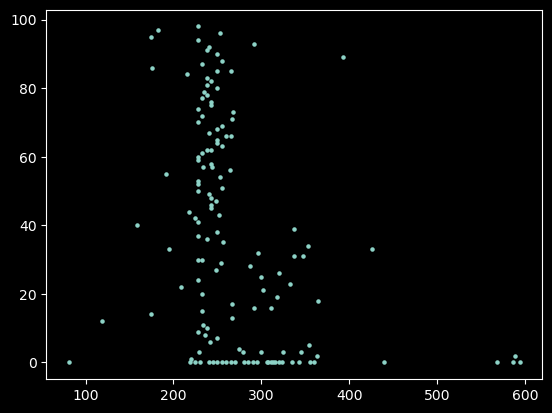

In [212]:
plt.figure()
plt.scatter(*np.where(sanity_check==1), s=5)
plt.show()

In [216]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
patterns[counts>=2], counts[counts>=2], [len(k) for k in pattern_template[patterns[counts>=2]]]

(array([ 0,  2,  3, 16, 30, 31, 33, 57, 62, 66, 85], dtype=int64),
 array([30,  2,  5,  2,  2,  2,  2,  2,  2,  2,  2]),
 [2, 3, 4, 67, 68, 181, 76, 298, 355, 25, 38])

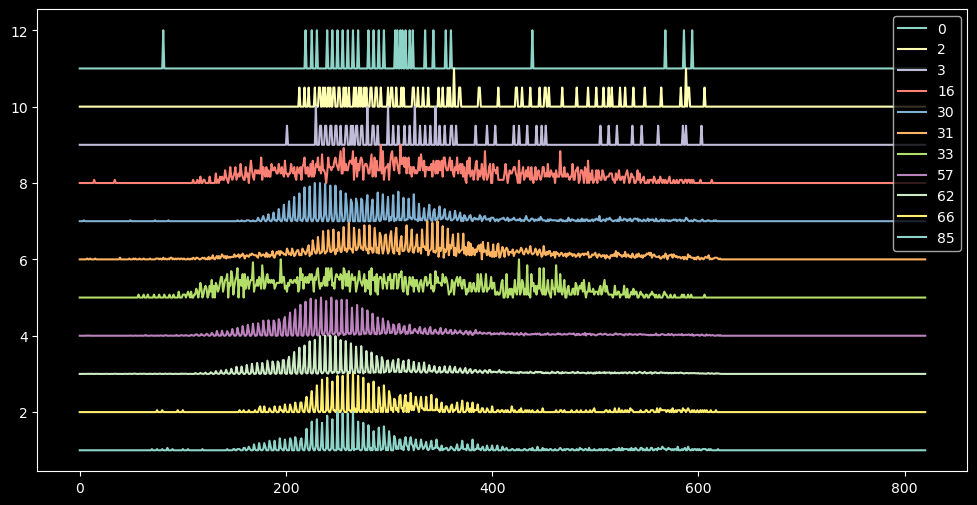

In [219]:
plt.figure(figsize=(12,6))
for i,k in enumerate(patterns[counts>=2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>=2])-i,label=k)
    plt.legend()
plt.show()

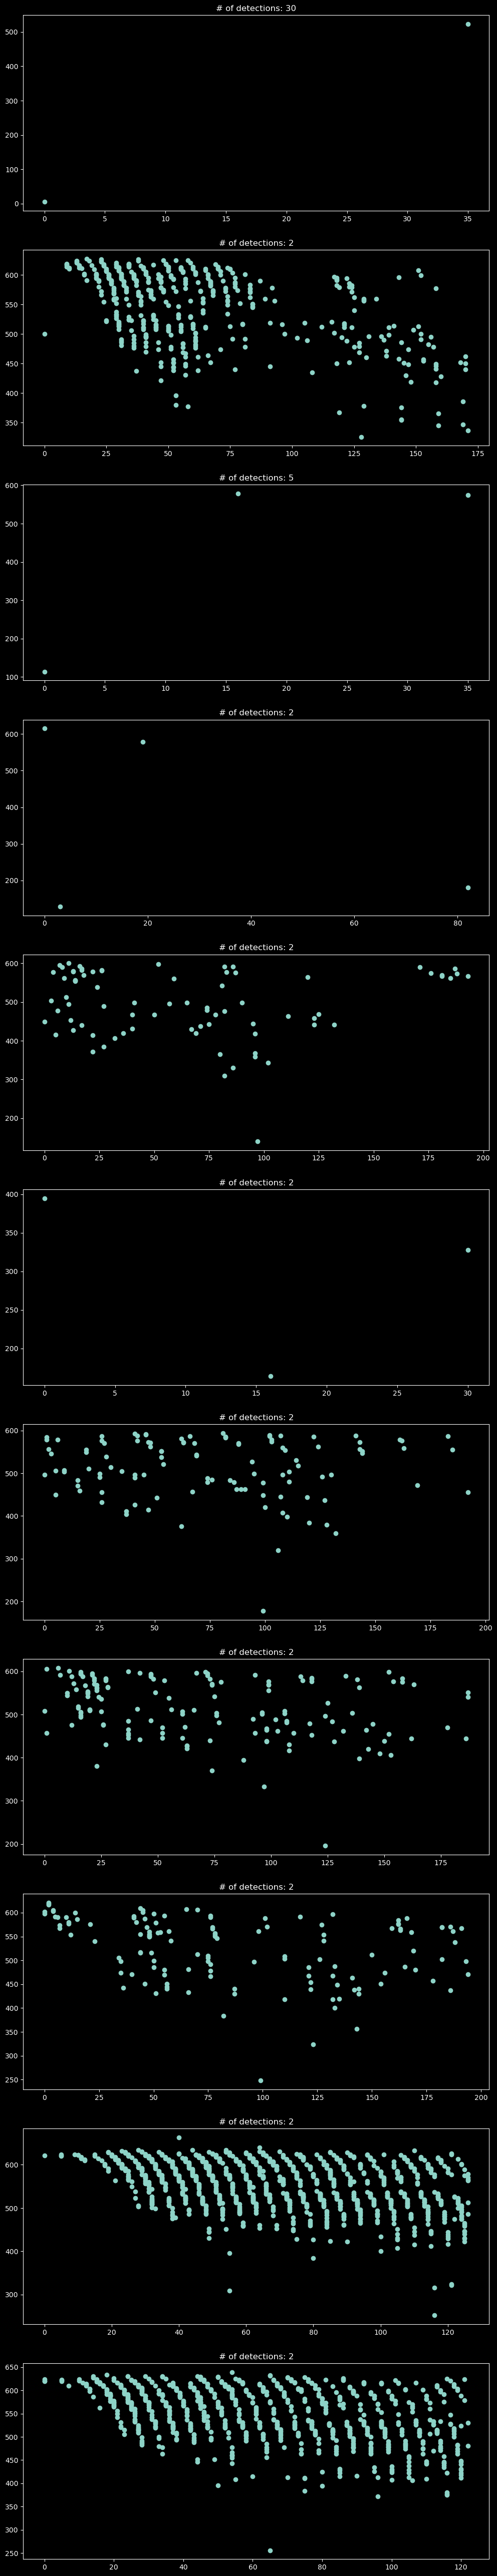

In [226]:
fig,ax = plt.subplots(len(patterns[counts>=2]),figsize=(12,6*len(patterns[counts>=2])))
for i in range(len(patterns[counts>=2])):
    ax[i].scatter(*pattern_template[i].T)
    ax[i].set_title(f'# of detections: {counts[counts>=2][i]}')
plt.show()

## Combined spoken numbers

In [14]:
# Let's concatenate numbers and see if anything comes of that? 
# Let's first find rasters with few numbers of spikes to not overwhelm the algorithm... also in theory that means it's less noisy right?


In [15]:
test = np.array([len(f['spikes']['times'][j]) for j in filt_idc])
test, test[4],test[5] # let's combine these

(array([8186, 6891, 7115, 7525, 6073, 6640, 7286, 8559, 7625, 6738, 6792,
        7308, 6516, 6663, 7462, 7317, 7001, 7483, 7886, 7270, 8126, 6533,
        7159, 6833, 7041, 7272, 7344, 7606, 7201, 7440, 7212, 6990, 8635,
        6479, 7056, 7345, 8817, 7481, 6828, 7139, 6363, 7397, 8403, 7013,
        7434, 7320, 7963, 7583]),
 6073,
 6640)

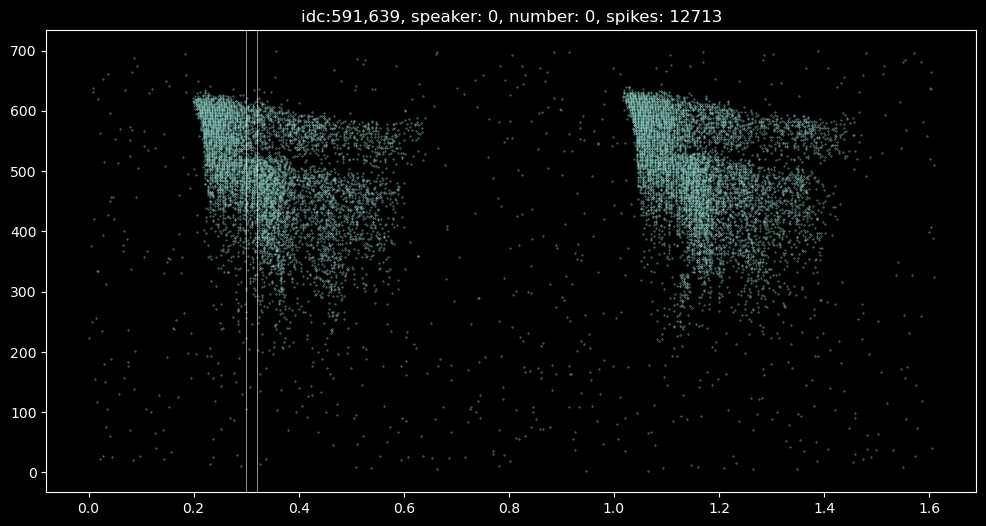

In [16]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))
i=filt_idc[4] 
j=filt_idc[5]
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
D=20/1000
times = np.hstack((f['spikes']['times'][i], np.max(f['spikes']['times'][i])+f['spikes']['times'][j]))
units = np.hstack((f['spikes']['units'][i], f['spikes']['units'][j]))
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

plt.title(f'idc:{i},{j}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.show()

In [17]:
# This is going to take forever to process... I could try to decrease the window size... that would help a lot I think
'''
How should I name this file?
'''

'\nHow should I name this file?\n'

In [19]:
# Convert the data into something that is easily readable by my parameter scan algo.
D=5/1000
filename = f'combined-{i}-{j}-{int(D*1000)}'

if not os.path.isfile(''.join((os.getcwd(),f'\\{filename}.pkl'))):
    pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = scan.scan_raster((times*1000).astype('int'), units,window_dim=int(D*1000))
    print(f'run_time: {window_time+cluster_time+sequence_time} s')

    results_scan = {
        'pattern_template':pattern_template,
        'sublist_keys_filt':sublist_keys_filt,
        'window_time':window_time,
        'cluster_time':cluster_time,
        'sequence_time':sequence_time
    }

    import pickle 
    with open(f'{filename}.pkl', 'wb') as file:  # open a text file
        pickle.dump(results_scan, file) # serialize the list
    file.close()
else:
    with open(f'{filename}.pkl', 'rb') as file:
        results_scan = pickle.load(file)
    file.close()
    print(f'{filename}.pkl loaded!')


12713 Windows


186 patterns found..... 99% 10.01 | opt_cutoff - 1.09 | most_detections - 6etections - 6
run_time: 43.7155556678772 s


In [22]:
pattern_template_copy, pattern_img = get_imgs(max(units),pattern_template)

In [23]:
raster = np.zeros((max((times*1000).astype('int'))+1, max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]-1]=1
print('done')

(1610, 699) (699, 19, 186)
done


In [24]:
D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

100%|████████████████████████████████████████████████████████████████████████████████| 186/186 [00:08<00:00, 20.98it/s]


In [26]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
patterns[counts>2], counts[counts>2], [len(k) for k in pattern_template[patterns[counts>2]]]

(array([  2,   5,   6,   7,  10,  20,  21,  27,  38,  87, 106, 111, 115,
        122, 144, 149, 163, 176, 183], dtype=int64),
 array([ 5, 31, 53, 12,  5, 21, 50, 61,  3,  3,  5,  4,  3,  3,  4,  4,  6,
         3,  3]),
 [7, 2, 2, 3, 1, 2, 2, 2, 6, 72, 17, 17, 46, 19, 10, 27, 5, 26, 11])

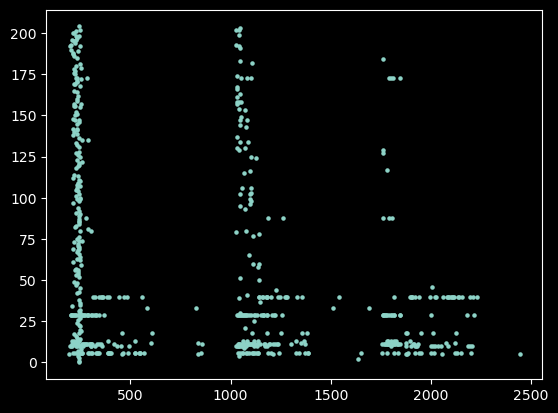

In [102]:
plt.figure()
plt.scatter(*np.where(sanity_check==1), s=5)
# plt.scatter(*np.where(sanity_check[:,patterns[counts>2]]==1), c='white',s=5)
plt.show()

0 2
1 5
2 6
3 7
4 10
5 20
6 21
7 27
8 38
9 87
10 106
11 111
12 115
13 122
14 144
15 149
16 163
17 176
18 183


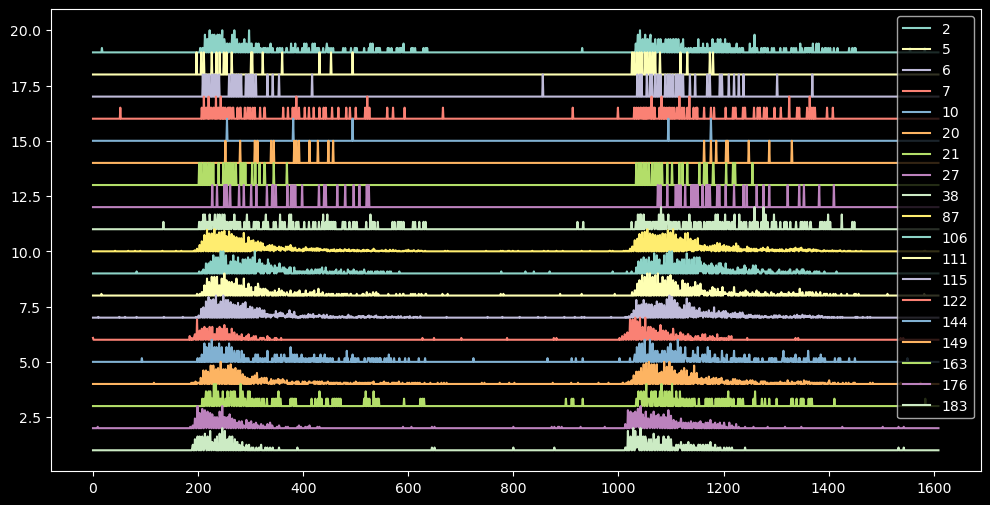

In [27]:
plt.figure(figsize=(12,6))
for i,k in enumerate(patterns[counts>2]):
    print(i,k)
    plt.plot(sanity_check[:,k]+len(patterns[counts>2])-i,label=k)
    plt.legend()
plt.show()

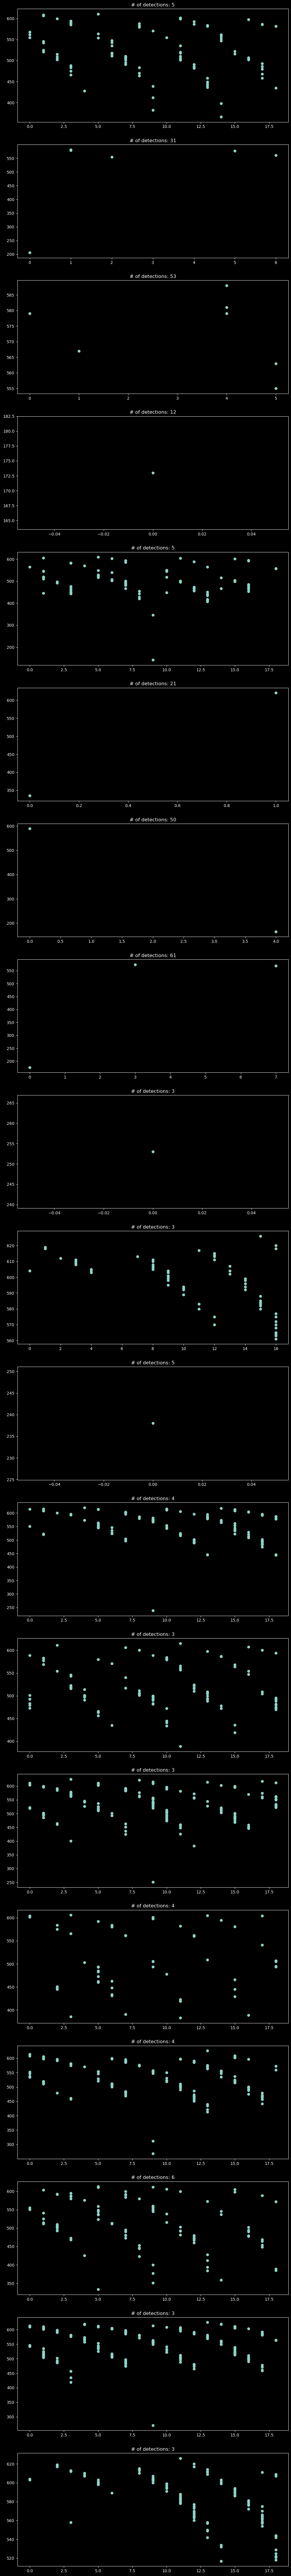

In [30]:
fig,ax = plt.subplots(len(patterns[counts>2]),figsize=(12,6*len(patterns[counts>2])))
for i in range(len(patterns[counts>2])):
    ax[i].scatter(*pattern_template[i].T)
    ax[i].set_title(f'# of detections: {counts[counts>2][i]}')
plt.show()

In [31]:
# Let's add in a different speaker and see if we can tell a difference...

## Combined spoken numbers two speakers

In [32]:
test = np.array([len(f['spikes']['times'][j]) for j in filt_idc])
test, test[4],test[5] # let's combine these

(array([8186, 6891, 7115, 7525, 6073, 6640, 7286, 8559, 7625, 6738, 6792,
        7308, 6516, 6663, 7462, 7317, 7001, 7483, 7886, 7270, 8126, 6533,
        7159, 6833, 7041, 7272, 7344, 7606, 7201, 7440, 7212, 6990, 8635,
        6479, 7056, 7345, 8817, 7481, 6828, 7139, 6363, 7397, 8403, 7013,
        7434, 7320, 7963, 7583]),
 6073,
 6640)

In [56]:
# let's find another number 0 from a different speaker
f['extra']['speaker'][np.array(f['labels'])==label]

array([ 3,  7,  7,  6,  1,  9,  6, 10,  3,  8,  0,  8,  9, 11,  2,  9,  9,
        9,  7,  0,  9,  8,  0,  7,  7,  2,  2,  7, 10, 11,  0, 10,  1,  2,
        0,  9, 10,  0, 11,  2,  0,  1,  7,  1,  2,  6,  0, 11,  0,  9, 10,
        3, 10,  0,  1,  0,  6,  8,  9,  9, 11,  1,  1,  6,  0,  2, 10,  8,
       11,  9,  9,  7,  1,  7,  8,  1,  6,  7,  6,  2,  6,  2,  0,  3,  6,
       10,  9,  0,  2,  8, 11,  0,  2,  2,  2,  1,  8,  8,  7, 11, 10,  7,
        1,  9,  0,  2, 11, 10,  3,  3,  3, 10,  1, 11,  6,  7, 10, 10,  2,
        9,  8,  7,  6,  6,  7,  8, 11,  0, 11,  2, 11,  2,  3,  7,  2,  3,
        3,  2,  6,  0,  8,  2,  8, 10,  1,  2,  8, 11, 10,  9, 11,  0,  8,
        8,  9,  7,  0,  6,  7, 10,  1, 11,  3,  8,  3,  2,  1,  2,  0, 10,
        1,  3,  2,  9,  7,  3,  2,  2, 10,  7,  1,  9,  0,  9, 11, 10,  8,
        9,  1,  7,  1,  7,  6,  2, 10,  3,  3, 10,  1, 10, 11, 10,  0,  8,
        6,  8,  0,  1,  9,  8,  8,  0,  0, 11,  0,  6,  7, 10,  9,  2, 10,
        7, 11,  6,  0,  0

In [60]:
new_idc = np.where(np.array(f['labels'])==label)[0][0]

In [65]:
np.hstack((idc,new_idc))

array([591, 639,   9], dtype=int64)

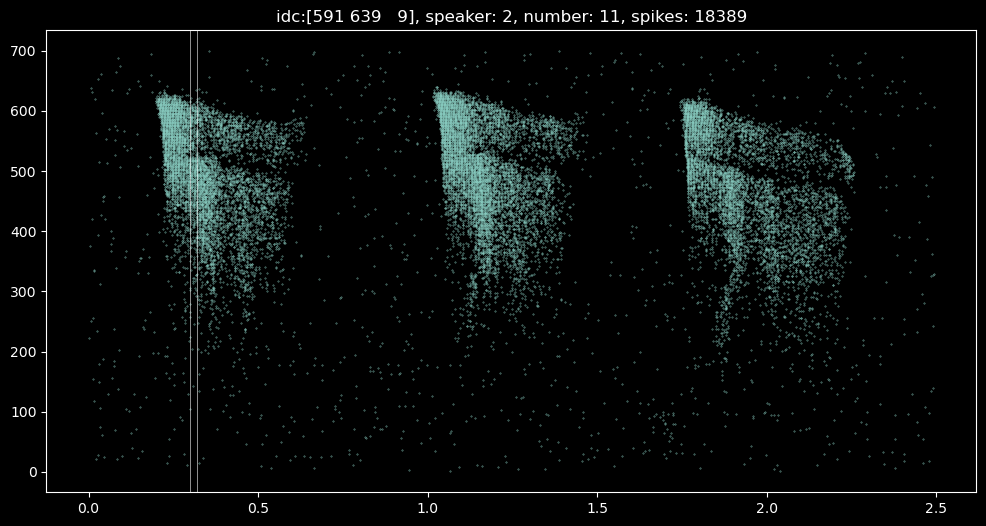

In [83]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))

new_idc = np.where(np.array(f['labels'])==label)[0][0]
idc=filt_idc[4:6] #+ new_idc
idc = np.hstack((idc,new_idc))

speaker = f['extra']['speaker'][i]
number = f['labels'][i]
D=20/1000
times = np.array([0])
units = np.array([])
for i in idc:
    times = np.hstack((times, np.max(times)+f['spikes']['times'][i]))
    units = np.hstack((units, f['spikes']['units'][i]))
units = units.astype('int')
times = np.delete(times,0)
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

plt.title(f'idc:{idc}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.show()

In [73]:
# Convert the data into something that is easily readable by my parameter scan algo.
D=5/1000
filename = f'combined-{idc}-{int(D*1000)}'

if not os.path.isfile(''.join((os.getcwd(),f'\\{filename}.pkl'))):
    pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = scan.scan_raster((times*1000).astype('int'), units.astype('int'),window_dim=int(D*1000))
    print(f'run_time: {window_time+cluster_time+sequence_time} s')

    results_scan = {
        'pattern_template':pattern_template,
        'sublist_keys_filt':sublist_keys_filt,
        'window_time':window_time,
        'cluster_time':cluster_time,
        'sequence_time':sequence_time
    }

    import pickle 
    with open(f'{filename}.pkl', 'wb') as file:  # open a text file
        pickle.dump(results_scan, file) # serialize the list
    file.close()
else:
    with open(f'{filename}.pkl', 'rb') as file:
        results_scan = pickle.load(file)
    file.close()
    print(f'{filename}.pkl loaded!')


18388 Windows


205 patterns found..... 100%10.01 | opt_cutoff - 1.09 | most_detections - 9etections - 9
run_time: 71.51841926574707 s


In [80]:
pattern_template_copy, pattern_img = get_imgs(max(units.astype('int')),pattern_template)

In [85]:
raster = np.zeros((max((times*1000).astype('int'))+1, max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]-1]=1
print('done')

(2495, 699) (699, 19, 205)
done


In [86]:
D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 14.51it/s]


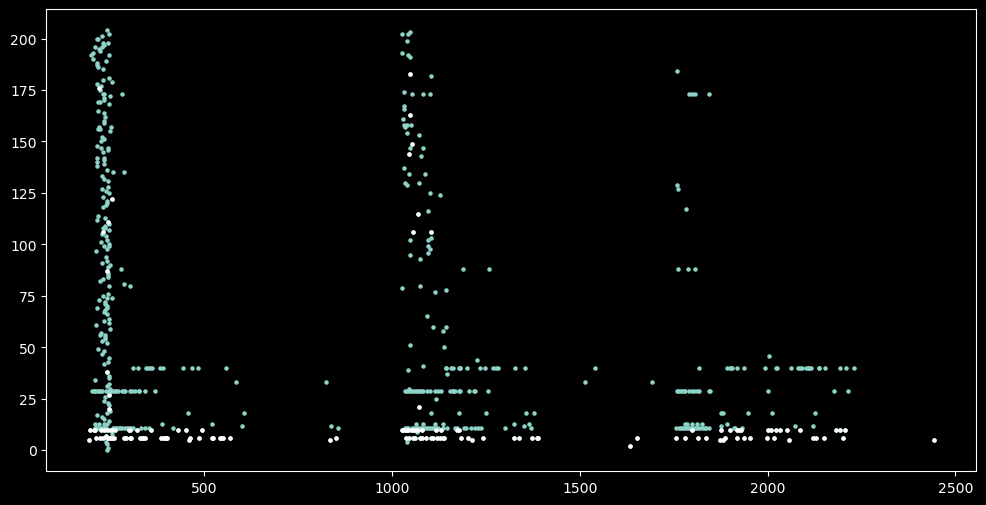

In [140]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>2][np.where(sanity_check[:,patterns[counts>2]]==1)[1]], np.where(sanity_check[:,patterns[counts>2]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

0 2
1 5
2 6
3 7
4 10
5 20
6 21
7 27
8 38
9 87
10 106
11 111
12 115
13 122
14 144
15 149
16 163
17 176
18 183


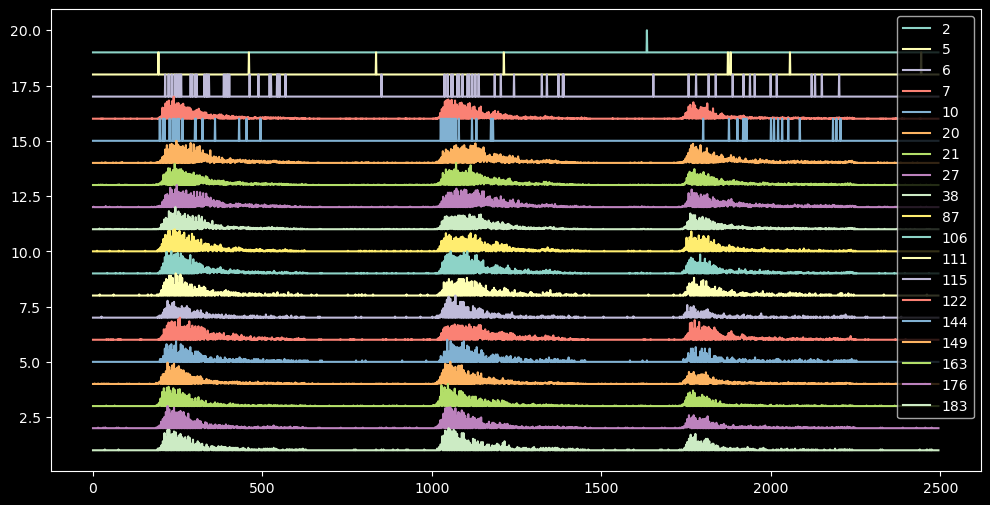

In [141]:
plt.figure(figsize=(12,6))
for i,k in enumerate(patterns[counts>2]):
    print(i,k)
    plt.plot(sanity_check[:,k]+len(patterns[counts>2])-i,label=k)
    plt.legend()
plt.show()